In [ ]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_core.tools import tool
from langchain_community.utilities.wikipedia import WikipediaAPIWrapper
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import MessagesState, StateGraph



load_dotenv()

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

llm = ChatOpenAI(model="gpt-4o-mini")
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
vector_store = Chroma(
    collection_name="interview_books",
    embedding_function=embeddings,
    persist_directory="embedings/chroma_langchain_books_db",  
)

Load boooks for interview 

In [72]:
import os
from langchain.document_loaders import PyPDFLoader

pdf_directory = "pdfs"
all_documents = []

for filename in os.listdir(pdf_directory):
    if filename.endswith(".pdf"):
        file_path = os.path.join(pdf_directory, filename)
        loader = PyPDFLoader(file_path)
        documents = loader.load()

        for doc in documents:
            doc.metadata["source"] = filename

        all_documents.extend(documents) 

In [7]:
type(all_documents[0])

langchain_core.documents.base.Document

Create books pages splits embedings 

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(all_documents)

_ = vector_store.add_documents(documents=all_splits)

Define computational graph 

In [ ]:
graph_builder = StateGraph(MessagesState)

# Wikipedia API Wrapper Tool
wikipedia_tool = WikipediaAPIWrapper(load_all_available_meta= True)


"function that defines agent tool, returns retrieved subdocs and meta info such as book name and page"
@tool(response_format="content_and_artifact")
def document_tool(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=5)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs


@tool(response_format="content_and_artifact")
def wikipedia_data(query: str):
    """Retrieve a summary from Wikipedia for a given query."""
    
    summary = wikipedia_tool.run(query)
    
    
    
    return summary


"define graph nodes by functions each graph nodes executes"

def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    
    prompt = """
    If the user's message requires information available in the documents, use the `document_tool` to retrieve relevant content. 
    If no relevant content is found in the documents or if additional context is needed, use the `wikipedia_data` tool to fetch a Wikipedia summary.
    Provide a detailed response to the user's question, referencing both:
    1. The content retrieved from documents (book chapters, articles, etc.).
    2. A relevant Wikipedia article, including a link for further reading.

    If both tools provide useful information, combine them to give the user a complete answer and reference both the document content and the Wikipedia article.
    """
    
    messages_with_prompt = [{"role": "system", "content": prompt}] + state["messages"]

    llm_with_tools = llm.bind_tools([document_tool,wikipedia_data])
    
    # Invoke the LLM with the current message context
    response = llm_with_tools.invoke(messages_with_prompt)
    
    # MessagesState appends responses to state instead of overwriting
    return {"messages": [response]}


tools = ToolNode([document_tool,wikipedia_data])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer based on retrieved content from both tools."""
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Separate content from Wikipedia and document tools

    docs_content = "\n\n".join(doc.content for doc in tool_messages)
   
    # System message content
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Keep the answer concise."
        "\n\n"
        f"{docs_content}"
    )

    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run LLM
    response = llm.invoke(prompt)

    return {"messages": [response]}


# Ensure that we only transition to the 'generate' step if relevant content is found
graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

# Entry point for the graph is `query_or_respond`
graph_builder.set_entry_point("query_or_respond")

# Define the conditional edges based on whether tools were used or not
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)

graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)
graph = graph_builder.compile()


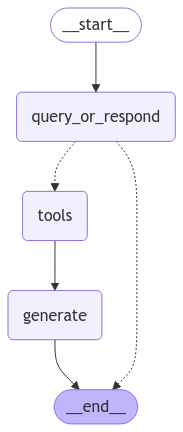

In [99]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [96]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I assist you today?


In [97]:
input_message = "Explain singular value decomposition"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Explain singular value decomposition
================================== Ai Message ==================================
Tool Calls:
  wikipedia_data (call_KQTvRwT4eeaWEKkj1FiHZDAf)
 Call ID: call_KQTvRwT4eeaWEKkj1FiHZDAf
  Args:
    query: Singular value decomposition
  document_tool (call_oSZUEYXI6Ci3bcALTTYwG3gT)
 Call ID: call_oSZUEYXI6Ci3bcALTTYwG3gT
  Args:
    query: singular value decomposition
================================= Tool Message =================================
Name: document_tool

Source: {'page': 135, 'source': 'mml-book.pdf'}
Content: 130 Matrix Decompositions
Figure 4.11 Image
processing with the
SVD. (a) The
original grayscale
image is a
1, 432 × 1, 910
matrix of values
between 0 (black)
and 1 (white).
(b)–(f) Rank-1
matrices
A1, . . . ,A5 and
their corresponding
singular values
σ1, . . . , σ5. The
grid-like structure of
each rank-1 matrix
is imposed by the
outer-product of the
left

In [98]:
input_message = "How BFS search is done? "

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

How BFS search is done? 
================================== Ai Message ==================================
Tool Calls:
  wikipedia_data (call_k8cwB6H9johdJJeDDZnaw1Ky)
 Call ID: call_k8cwB6H9johdJJeDDZnaw1Ky
  Args:
    query: Breadth-first search
  document_tool (call_73ifhhIxcsHO6bQtbMRBqRWg)
 Call ID: call_73ifhhIxcsHO6bQtbMRBqRWg
  Args:
    query: BFS search
================================= Tool Message =================================
Name: document_tool

Source: {'page': 615, 'source': '[Cormen-AL2011]Introduction_To_Algorithms-A3.pdf'}
Content: 22.2 Breadth-ﬁrst search 595
The breadth-ﬁrst-search procedure BFS below assumes that the input graph
G D.V; E/ is represented using adjacency lists. It attaches several additional
attributes to each vertex in the graph. We store the color of each vertex u 2V
in the attribute u:color and the predecessor of u in the attribute u:/EM.I f u has no
predecessor 